## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

if not os.path.exists("jet.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/jet.bmp --no-check-certificate



--2021-11-24 17:36:07--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/jet.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263224 (257K) [image/bmp]
Saving to: ‘jet.bmp’

jet.bmp             100%[===================>] 257,05K  --.-KB/s    in 0,08s   

2021-11-24 17:36:08 (3,14 MB/s) - ‘jet.bmp’ saved [263224/263224]



In [39]:
def BBHE(img):
    lm = img.mean()

    hist_origin = cv2.calcHist(img, [0], None, [256], [0, 256])
    
    h1 = hist_origin[:int(lm)]
    h2 = hist_origin[int(lm):]

    c1 = h1.cumsum()
    c2 = h2.cumsum()

    c1 /= c1.max()
    c2 /= c2.max()

    c1 *= lm
    c2 *= lm + 1 + (255 - lm - 1) * c2

    s = np.append(c1, c2)

    result = img[:][:]

    for line in result:
        for pix in line:
            pix = s[pix]

    return result

In [52]:
def DSIHE(img):
    
    hist_origin = cv2.calcHist(img, [0], None, [256], [0, 256])
    cum_origin = hist_origin.cumsum()

    cum_origin = np.abs(cum_origin - cum_origin.max()/2)

    lm_index = 0

    for i, el in enumerate(cum_origin):
        if el < cum_origin[lm_index]:
            lm_index = i

    lm = hist_origin.cumsum()[lm_index]

    h1 = hist_origin[:int(lm)]
    h2 = hist_origin[int(lm):]

    c1 = h1.cumsum()
    c2 = h2.cumsum()

    c1 /= c1.max()
    c2 /= c2.max()

    c1 *= lm
    c2 *= lm + 1 + (255 - lm - 1) * c2

    s = np.append(c1, c2)

    result = img[:][:]

    for line in result:
        for pix in line:
            pix = s[pix]

    return result


<ipython-input-52-5d4eefc1ecdb>:23: RuntimeWarning: invalid value encountered in true_divide
  c2 /= c2.max()


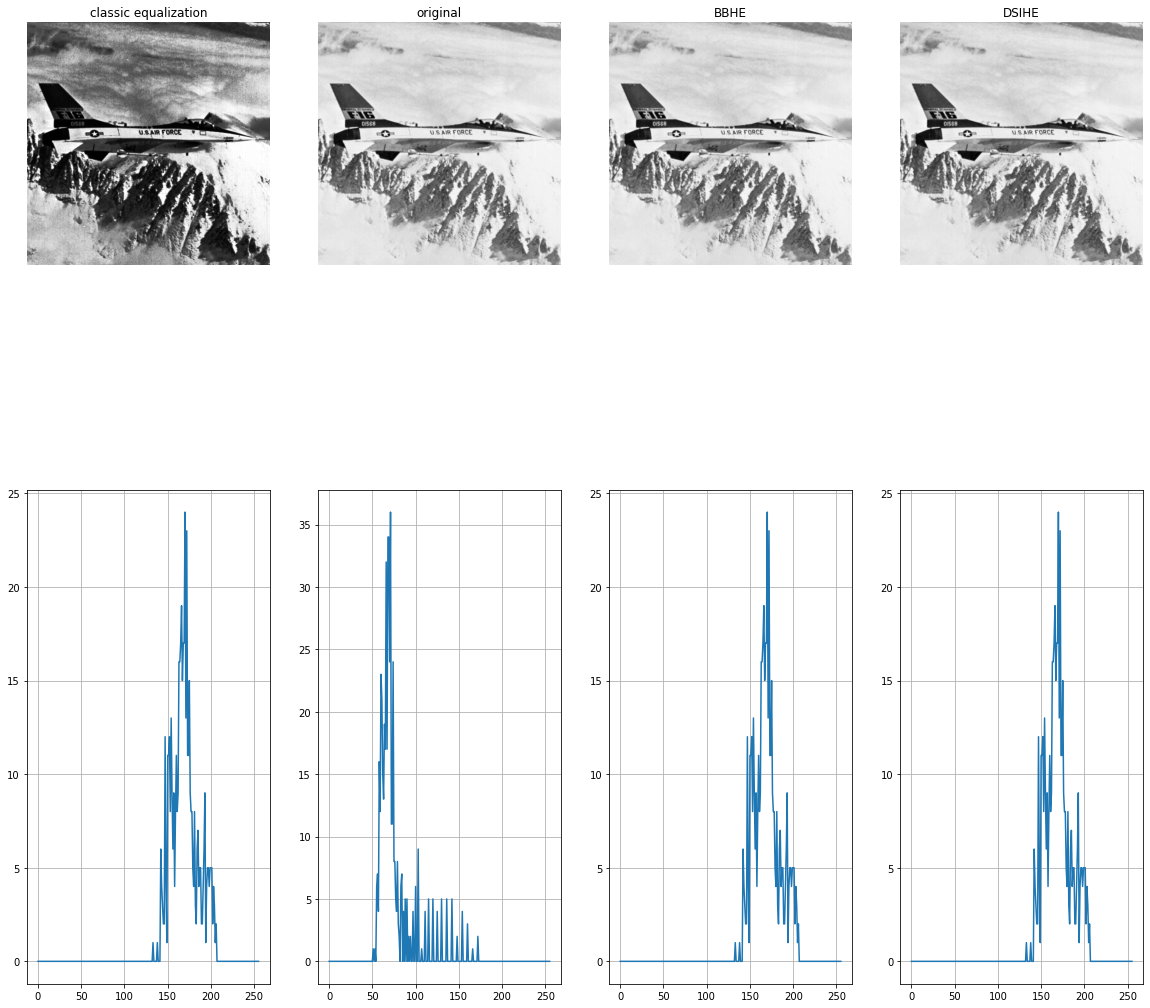

In [57]:
jet = cv2.imread("jet.bmp", cv2.COLOR_BGR2GRAY)

jet_classic = cv2.equalizeHist(jet)

f, ax = plt.subplots(2, 4)

f.set_size_inches(20, 20)

ax[0][1].imshow(jet, cmap='gray')
ax[0][1].set_title('original')
ax[0][1].axis('off')

ax[0][0].imshow(jet_classic, cmap='gray')
ax[0][0].set_title('classic equalization')
ax[0][0].axis('off')

bbhe_jet = BBHE(jet)
ax[0][2].imshow(bbhe_jet, cmap='gray')
ax[0][2].set_title('BBHE')
ax[0][2].axis('off')

dsihe_jet = DSIHE(jet)
ax[0][3].imshow(dsihe_jet, cmap='gray')
ax[0][3].set_title('DSIHE')
ax[0][3].axis('off')

ax[1][0].plot(cv2.calcHist(jet, [0], None, [256], [0, 256]))
ax[1][0].grid()
ax[1][1].plot(cv2.calcHist(jet_classic, [0], None, [256], [0, 256]))
ax[1][1].grid()
ax[1][2].plot(cv2.calcHist(bbhe_jet, [0], None, [256], [0, 256]))
ax[1][2].grid()
ax[1][3].plot(cv2.calcHist(dsihe_jet, [0], None, [256], [0, 256]))
ax[1][3].grid()

plt.show()